In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
import sys

# sys.path.append("../src")
from src.utils import load_or_download_data
from src.features.preprocess_data import DataProcessor
from src.models.train_model import ModelTrainer, HyperparameterTuner

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import sys
print(sys.path)


['/home/lqueiros/.local/share/uv/python/cpython-3.12.7-linux-x86_64-gnu/lib/python312.zip', '/home/lqueiros/.local/share/uv/python/cpython-3.12.7-linux-x86_64-gnu/lib/python3.12', '/home/lqueiros/.local/share/uv/python/cpython-3.12.7-linux-x86_64-gnu/lib/python3.12/lib-dynload', '', '/home/lqueiros/projects/ml_zoomcamp_2024_midterm_project/heart_disease_risk_prediction/.venv/lib/python3.12/site-packages', '..', '..', '..', '..', '..', '../', '../utils', '../src']


### About The Dataset :

**age**: Age of the patient

**sex**: Sex of the patient
 - 1 = Male
 
 - 0 = Female

**cp**: Chest pain type
 - 0 = Typical Angina

 - 1 = Atypical Angina

 - 2 = Non-anginal Pain

 - 3 = Asymptomatic

**trtbps**: Resting blood pressure (in mm Hg)

**chol**: Cholestoral in mg/dl fetched via BMI sensor

**fbs**: (fasting blood sugar > 120 mg/dl)
 - 1 = True

 - 0 = False

**restecg**: Resting electrocardiographic results
 - 0 = Normal 

 - 1 = ST-T wave normality

 - 2 = Left ventricular hypertrophy

**thalachh**: Maximum heart rate achieved

**oldpeak**: Previous peak. ST depression induced by exercise relative to rest

**slp**: Slope. The slope of the peak exercise ST segment
 - 0 = unsloping

 - 1 = flat

 - 2 = downsloping

**caa**: Number of major vessels ~ (0,3)

**thall**: Thalassemia. Thalium Stress Test result ~ (0,3)
 - 0 = null

 - 1 = fixed defect

 - 2 = normal

 - 3 = reversable defect

**exang**: Exercise induced angina 
 - 1 = Yes

 - 0 = No

**output**: Target variable. Diagnosis of heart disease (angiographic disease status)
 - 0 = < 50% diameter narrowing. less chance of heart disease

 - 1 = > 50% diameter narrowing. more chance of heart disease

## Loading the data


In [56]:
# This function will look for the data in the expected folder, if not present, it will download it from its source
heart_df =  load_or_download_data()
print(heart_df.shape)
heart_df.head()

File found at ../data/raw/heart_disease_original_data.csv. Loading data...
(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


## Preprocessing the data

In [57]:
# Define the numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Define the categorical columns by excluding numerical ones
categorical_cols = [col for col in heart_df.columns if col not in numerical_cols]

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']
Numerical Columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [ ]:
# Instantiating the data processing class
data_processor = DataProcessor(heart_df, numerical_cols, categorical_cols, 'num')

In [59]:
# Dropping rows with missing values
original_number_of_rows = heart_df.shape[0]
heart_df_cleaned = data_processor.clean_data().data

In [61]:
rows_dropped = original_number_of_rows - heart_df_cleaned.shape[0]
print(f"There were {rows_dropped} rows dropped due to containing missing data")

There were 6 rows dropped due to containing missing data


In [62]:
# Binarizing the target and changing the categorical features data type
heart_df_processed = data_processor.preprocess_data().data

In [64]:
heart_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       297 non-null    int64   
 1   sex       297 non-null    category
 2   cp        297 non-null    category
 3   trestbps  297 non-null    int64   
 4   chol      297 non-null    int64   
 5   fbs       297 non-null    category
 6   restecg   297 non-null    category
 7   thalach   297 non-null    int64   
 8   exang     297 non-null    category
 9   oldpeak   297 non-null    float64 
 10  slope     297 non-null    category
 11  ca        297 non-null    category
 12  thal      297 non-null    category
 13  num       297 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 17.8 KB


## Modelling

### Spliting the data into train, test and validation

In [23]:
X_train, y_train, X_test, y_test, X_val, y_val = data_processor.split_data()

Train set: (177, 13), Validation set: (60, 13), Test set: (60, 13)


### Training baseline models

In [24]:
# Define the models in a dictionary
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'XGBoost Classifier': XGBClassifier(eval_metric="logloss", enable_categorical=True),
    'Decision Tree': DecisionTreeClassifier()
}

In [ ]:
# Instantiating the model trainer class
ModelTrainer(models).train_models(X_train=X_train, y_train=y_train).evaluate_models(X_test=X_test, y_test=y_test)

Training Logistic Regression...
Training Support Vector Classifier...
Training XGBoost Classifier...


/home/lqueiros/projects/ml_zoomcamp_2024_midterm_project/heart_disease_risk_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Decision Tree...
************
All models trained! Next step is performance evaluation.
************
************
Evaluating Logistic Regression...
************
Confusion Matrix for Logistic Regression: 
[[28  2]
 [ 6 24]]
Accuracy of Logistic Regression: 86.67%
Precision of Logistic Regression: 92.31%
Recall of Logistic Regression: 80.00%
F1 Score of Logistic Regression: 85.71%


Evaluating Support Vector Classifier...
************
Confusion Matrix for Support Vector Classifier: 
[[25  5]
 [18 12]]
Accuracy of Support Vector Classifier: 61.67%
Precision of Support Vector Classifier: 70.59%
Recall of Support Vector Classifier: 40.00%
F1 Score of Support Vector Classifier: 51.06%


Evaluating XGBoost Classifier...
************
Confusion Matrix for XGBoost Classifier: 
[[25  5]
 [ 7 23]]
Accuracy of XGBoost Classifier: 80.00%
Precision of XGBoost Classifier: 82.14%
Recall of XGBoost Classifier: 76.67%
F1 Score of XGBoost Classifier: 79.31%


Evaluating Decision Tree...
**********

### Hyperparameter Tuning

In [ ]:
# Defining the parameter grid
model_param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            "penalty": ["l1", "l2"],
            "C": [0.01, 0.1, 1, 5, 10],
            "solver": ["liblinear"],# "saga"],
        },
    },
    "Support Vector Classifier": {
        "model": SVC(),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly", "sigmoid"],
            "gamma": ["scale", "auto"],
        },
    },
    "XGBoost Classifier": {
    "model": XGBClassifier(eval_metric="logloss", enable_categorical=True),
    "params": {
        "learning_rate": [0.02, 0.05, 0.1],  # Smaller learning rates for better generalization
        "n_estimators": [50, 100],    # Number of boosting rounds
        "max_depth": [3, 5, 10],      # Limit depth to control model complexity
        "min_child_weight": [1, 3],   # Minimum sum of instance weights in a child
        "gamma": [0, 0.1, 0.3],       # Minimum loss reduction to make a split
        "subsample": [0.8, 1.0],      # Fraction of samples for each tree
        "colsample_bytree": [0.8, 1.0],  # Fraction of features for each tree
        "reg_alpha": [0, 0.1, 1.0],   # L1 regularization
        "reg_lambda": [1.0, 2.0],     # L2 regularization
        },
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
        },
    },
}

In [ ]:
# Instantiating the hyperparameter tuner class
model_tuner = HyperparameterTuner(model_param_grids)

#### Scoring metrics

Because this is a medical problematic, the best score to tune the models to is recall, in order to reduce the number of false negatives

In [ ]:
# Tuning the models and retrieving the best performant ones on recall
best_models = model_tuner.tune_models(X_train=X_train, y_train=y_train)

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score for Logistic Regression: 0.772

Tuning hyperparameters for Support Vector Classifier...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for Support Vector Classifier: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Recall Score for Support Vector Classifier: 0.736

Tuning hyperparameters for XGBoost Classifier...
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Best Parameters for XGBoost Classifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}
Best Recall Score for XGBoost Classifier: 0.784

Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_s

In [ ]:
# Looking into the trainde models
best_models

{'Logistic Regression': {'best_estimator': LogisticRegression(C=10, penalty='l1', solver='liblinear'),
  'best_params': {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'},
  'best_score': np.float64(0.7720588235294118)},
 'Support Vector Classifier': {'best_estimator': SVC(C=0.1, kernel='linear'),
  'best_params': {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
  'best_score': np.float64(0.7360294117647059)},
 'XGBoost Classifier': {'best_estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=True, eval_metric='logloss',
                feature_types=None, gamma=0, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.05, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=3

In [ ]:
# Selecting the best performing model
best_model = model_tuner.get_best_models()

Best Model: XGBoost Classifier
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}
Best Score: 0.783

In [70]:
print(f"The best performing model after tuning is {best_model.best_model[0]}")

The best performing model after tuning is XGBoost Classifier


#### Saving the model

In [43]:
model_tuner.save_best_model_to_pickle(filepath="../models/trained_model")

Best model saved to ../models/trained_model.pkl


In [29]:
# Extract the best-performing model
best_model = max(best_models.items(), key=lambda x: x[1]["best_score"])

# Display the best model's information
best_model_name, best_model_info = best_model
print(f"Best Model: {best_model_name}")
print(f"Best Estimator: {best_model_info['best_estimator']}")
print(f"Best Params: {best_model_info['best_params']}")
print(f"Best Score: {best_model_info['best_score']}")

Best Model: XGBoost Classifier
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}
Best Score: 0.783

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 101 to 79
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       177 non-null    int64   
 1   sex       177 non-null    category
 2   cp        177 non-null    category
 3   trestbps  177 non-null    int64   
 4   chol      177 non-null    int64   
 5   fbs       177 non-null    category
 6   restecg   177 non-null    category
 7   thalach   177 non-null    int64   
 8   exang     177 non-null    category
 9   oldpeak   177 non-null    float64 
 10  slope     177 non-null    category
 11  ca        177 non-null    category
 12  thal      177 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 10.8 KB


In [ ]:
# heart_df['num'] = [1 if x > 0 else 0 for x in heart_df['num'].values]


In [ ]:
# # Convert categorical columns to 'category' dtype
# for col in categorical_cols:
#     heart_df[col] = heart_df[col].astype('category')

In [ ]:
# heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       297 non-null    int64   
 1   sex       297 non-null    category
 2   cp        297 non-null    category
 3   trestbps  297 non-null    int64   
 4   chol      297 non-null    int64   
 5   fbs       297 non-null    category
 6   restecg   297 non-null    category
 7   thalach   297 non-null    int64   
 8   exang     297 non-null    category
 9   oldpeak   297 non-null    float64 
 10  slope     297 non-null    category
 11  ca        297 non-null    category
 12  thal      297 non-null    category
 13  num       297 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 17.8 KB


In [ ]:
# heart_df['num'].value_counts()

num
0    160
1    137
Name: count, dtype: int64

In [ ]:
# for col in categorical_cols:
#     heart_df[col] = LabelEncoder().fit_transform(heart_df[col])

In [ ]:
# df_full_train, df_val = train_test_split(
#     heart_df, test_size=0.2, random_state=1)
# df_train, df_test = train_test_split(
#     df_full_train, test_size=0.25, random_state=1)

# X_train = df_train.drop(columns=["num"])
# y_train = df_train["num"]

# X_val = df_val.drop(columns=["num"])
# y_val = df_val["num"]

# X_test = df_test.drop(columns=["num"])
# y_test = df_test["num"]


# # Output the shapes of the splits to verify
# print(
#     f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}"
# )

Train set: (177, 13), Validation set: (60, 13), Test set: (60, 13)


In [ ]:
# # Convert DataFrames to dictionaries
# train_dict = X_train[categorical_cols[:-1] + numerical_cols].to_dict(orient="records")
# val_dict = X_val[categorical_cols[:-1] + numerical_cols].to_dict(orient="records")

# # Initialize the DictVectorizer
# dv = DictVectorizer(sparse=True)

# # Fit and transform the training data
# X_train_encoded = dv.fit_transform(train_dict)

# # Transform the validation data
# X_val_encoded = dv.transform(val_dict)

In [ ]:
# x = heart_df.iloc[:, 1:-1].values
# y = heart_df.iloc[:, -1].values
# x,y

(array([[  1.,   1., 145., ...,   3.,   0.,   6.],
        [  1.,   4., 160., ...,   2.,   3.,   3.],
        [  1.,   4., 120., ...,   2.,   2.,   7.],
        ...,
        [  1.,   4., 144., ...,   2.,   2.,   7.],
        [  1.,   4., 130., ...,   2.,   1.,   7.],
        [  0.,   2., 130., ...,   2.,   1.,   3.]]),
 array([0, 2, 1, 0, 0, 0, 3, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 3, 4, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 0, 3, 1, 3, 0, 4, 0, 0, 0,
        1, 4, 0, 4, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2,
        1, 0, 2, 1, 0, 3, 1, 1, 1, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 2, 3, 1,
        1, 0, 2, 2, 0, 0, 0, 3, 2, 3, 4, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 4, 3, 1, 0, 0, 1, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 4, 3,
        1, 1, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 4, 1, 0, 1,
        0, 0, 3, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 3, 2, 0, 3, 0, 0, 0, 1, 0,
        0, 0,

In [ ]:
# y_bin = np.where(y > 0, 1, 0)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x, y_bin, test_size= 0.2, random_state= 0)

In [ ]:
# print('Shape for training data', x_train.shape, y_train.shape)
# print('Shape for testing data', x_test.shape, y_test.shape)

Shape for training data (237, 12) (237,)
Shape for testing data (60, 12) (60,)


In [ ]:
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [ ]:
# x_train,x_test

(array([[-1.41421356,  0.86030302,  2.00921916, ...,  0.60949041,
          1.41086898,  0.62092128],
        [-1.41421356,  0.86030302, -0.16191929, ...,  0.60949041,
         -0.71215291, -0.91731925],
        [ 0.70710678,  0.86030302, -0.81326083, ...,  0.60949041,
         -0.71215291,  1.13366813],
        ...,
        [ 0.70710678,  0.86030302, -0.16191929, ..., -0.97786373,
          2.47237993,  1.13366813],
        [ 0.70710678,  0.86030302,  0.92364993, ...,  0.60949041,
         -0.71215291,  1.13366813],
        [ 0.70710678,  0.86030302,  0.65225763, ...,  0.60949041,
          1.41086898,  0.62092128]]),
 array([[ 7.07106781e-01, -2.24464850e+00, -8.13260825e-01,
         -1.20761374e+00, -4.36983723e-01,  1.03436270e+00,
          1.76643960e+00, -7.20576692e-01, -9.10050057e-01,
          6.09490408e-01, -7.12152913e-01,  6.20921283e-01],
        [-1.41421356e+00,  8.60303023e-01, -1.68171620e+00,
          3.33847403e-01, -4.36983723e-01,  1.03436270e+00,
         -1.

Training Logistic Regression...
Confusion Matrix for Logistic Regression: 
[[28  2]
 [ 7 23]]
Accuracy of Logistic Regression: 85.00%
Precision of Logistic Regression: 92.00%
Recall of Logistic Regression: 76.67%
F1 Score of Logistic Regression: 83.64%


Training Support Vector Classifier...
Confusion Matrix for Support Vector Classifier: 
[[29  1]
 [20 10]]
Accuracy of Support Vector Classifier: 65.00%
Precision of Support Vector Classifier: 90.91%
Recall of Support Vector Classifier: 33.33%
F1 Score of Support Vector Classifier: 48.78%


Training XGBoost Classifier...


/home/lqueiros/projects/ml_zoomcamp_2024_midterm_project/heart_disease_risk_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for XGBoost Classifier: 
[[24  6]
 [ 4 26]]
Accuracy of XGBoost Classifier: 83.33%
Precision of XGBoost Classifier: 81.25%
Recall of XGBoost Classifier: 86.67%
F1 Score of XGBoost Classifier: 83.87%


Training Decision Tree...


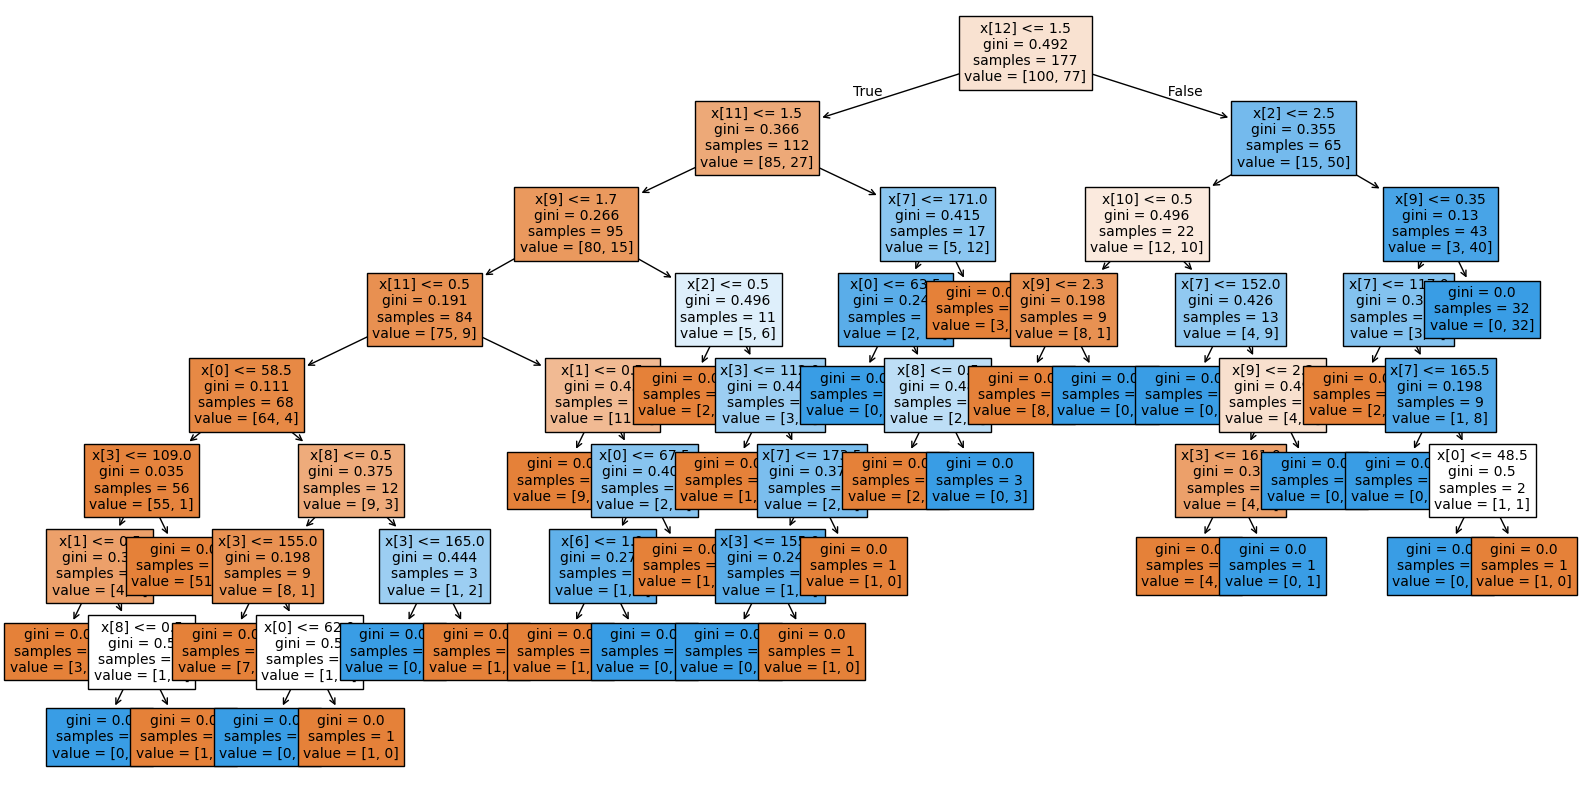

Confusion Matrix for Decision Tree: 
[[24  6]
 [ 6 24]]
Accuracy of Decision Tree: 80.00%
Precision of Decision Tree: 80.00%
Recall of Decision Tree: 80.00%
F1 Score of Decision Tree: 80.00%




In [78]:
# Define the models in a dictionary
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    # 'LightGBM Classifier': LGBMClassifier(force_row_wise=True, min_child_samples=50, num_leaves=31, min_split_gain=0.01),
    'XGBoost Classifier': XGBClassifier(eval_metric="logloss", enable_categorical=True),
    'Decision Tree': DecisionTreeClassifier()
}

# Iterate through the dictionary, fit each model, and print the results
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    # Compute confusion matrix
    conf = confusion_matrix(y_test, predicted)

    # Compute accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average='binary') * 100
    recall = recall_score(y_test, predicted, average='binary') * 100
    f1 = f1_score(y_test, predicted, average='binary') * 100

    # Plot decision tree for Decision Tree Classifier
    if model_name == 'Decision Tree':
        plt.figure(figsize=(20, 10))
        plot_tree(model, filled=True, fontsize=10)
        plt.show()

    # Print results
    print(f"Confusion Matrix for {model_name}: \n{conf}")
    print(f"Accuracy of {model_name}: {accuracy:.2f}%")
    print(f"Precision of {model_name}: {precision:.2f}%")
    print(f"Recall of {model_name}: {recall:.2f}%")
    print(f"F1 Score of {model_name}: {f1:.2f}%")
    print("\n" + "="*60 + "\n")

In [ ]:
# Define models and their parameter grids
model_param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            "penalty": ["l1", "l2"],
            "C": [0.01, 0.1, 1, 5, 10],
            "solver": ["liblinear"],# "saga"],
        },
    },
    "Support Vector Classifier": {
        "model": SVC(),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly", "sigmoid"],
            "gamma": ["scale", "auto"],
        },
    },
    # "LightGBM Classifier": {
    #     "model": LGBMClassifier(force_row_wise=True),
    #     "params": {
    #         "num_leaves": [15, 31, 50],
    #         "learning_rate": [0.01, 0.1, 0.2],
    #         "n_estimators": [50, 100, 200],
    #         "max_depth": [3, 5, 10, 30],
    #         "min_child_samples": [10, 20, 30],
    #     },
    # },
    # "LightGBM Classifier": {
    #     "model": LGBMClassifier(force_row_wise=True),
    #     "params": {
    #         "num_leaves": [15, 31],  # Small range, fewer combinations
    #         "learning_rate": [0.01, 0.1],  # Focus on commonly effective values
    #         "n_estimators": [50, 100],  # Cap iterations to prevent overfitting
    #         "max_depth": [3, 5, 10],  # Limit depth to control model complexity
    #         "min_child_samples": [10, 20],  # Small ranges for fewer splits
    #         "colsample_bytree": [0.7, 0.9],  # Feature subsampling for diversity
    #         "subsample": [0.8, 1.0],  # Row sampling for regularization
    #     },
    # },
    "XGBoost Classifier": {
    "model": XGBClassifier(eval_metric="logloss", enable_categorical=True),
    "params": {
        "learning_rate": [0.01, 0.1],  # Smaller learning rates for better generalization
        "n_estimators": [50, 100],    # Number of boosting rounds
        "max_depth": [3, 5, 10],      # Limit depth to control model complexity
        "min_child_weight": [1, 3],   # Minimum sum of instance weights in a child
        "gamma": [0, 0.1, 0.3],       # Minimum loss reduction to make a split
        "subsample": [0.8, 1.0],      # Fraction of samples for each tree
        "colsample_bytree": [0.8, 1.0],  # Fraction of features for each tree
        "scale_pos_weight": [1, 3],   # Handle class imbalance
        "reg_alpha": [0, 0.1, 1.0],   # L1 regularization
        "reg_lambda": [1.0, 2.0],     # L2 regularization
        },
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
        },
    },
}

# Iterate through each model and perform GridSearchCV
best_models = {}
for model_name, model_info in model_param_grids.items():
    print(f"Tuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["params"],
        scoring="recall",
        cv=5,
        verbose=1,
        error_score="raise",
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)

    # Store the best model and parameters
    best_models[model_name] = {
        "best_estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Recall Score for {model_name}: {grid_search.best_score_:.3f}\n")

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Logistic Regression: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score for Logistic Regression: 0.767

Tuning hyperparameters for Support Vector Classifier...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Recall Score for Support Vector Classifier: 0.754

Tuning hyperparameters for XGBoost Classifier...
Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
Best Parameters for XGBoost Classifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 2.0, 'scale_pos_weight': 3, 'subsample': 0.8}
Best Recall Score for XGBoost Classifier: 1.000

Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 54 candi

In [58]:
best_models.keys()

dict_keys(['Logistic Regression', 'Support Vector Classifier', 'XGBoost Classifier', 'Decision Tree'])

In [60]:
xgb_model = best_models['XGBoost Classifier']['best_estimator']

In [62]:
y_test_predict = xgb_model.predict(X_test)

In [63]:
recall_score(y_pred=y_test_predict, y_true=y_test)

np.float64(1.0)

In [64]:
y_val_predict = xgb_model.predict(X_val)

In [65]:
recall_score(y_pred=y_val_predict, y_true=y_val)

np.float64(1.0)